# Optimizing __U-net__ for Segmentation.
- ### Quantization
- ### Prunning
- ### Mixed Precission
 

RUN on .conda (Python 3.10.16) enviroment.

## Download the data at:

### Data Source: https://www.robots.ox.ac.uk/~vgg/data/pets/

In [84]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import psutil
from tensorflow.keras import backend as K
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow_model_optimization as tfmot

In [85]:
# Define dataset directory
IMG_SIZE = (128, 128)
DATASET_PATH = "oxford-iiit-pet"  # <-- CHANGE THIS TO YOUR DIRECTORY
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
MASKS_PATH = os.path.join(DATASET_PATH, "annotations/trimaps")

# Get sorted file lists
image_files = sorted([os.path.join(IMAGES_PATH, f) for f in os.listdir(IMAGES_PATH) if f.endswith(".jpg")])
mask_files = sorted([os.path.join(MASKS_PATH, f) for f in os.listdir(MASKS_PATH) if f.endswith(".png")])

# Ensure image-mask pairs match
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"

print(f"Total images: {len(image_files)}, Total masks: {len(mask_files)}")

Total images: 7390, Total masks: 7390


In [87]:
def load_image_and_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE) / 255.0  # Normalize to [0,1]

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)  # Keep single channel
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest")
    mask = tf.where(mask > 1, 1, 0)  # Convert to binary: 0 = background, 1 = pet

    return image, mask

def display_sample(dataset):
    for images, masks in dataset.take(1):
        fig, ax = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(5):
            ax[0, i].imshow(images[i])
            ax[0, i].set_title("Image")
            ax[1, i].imshow(masks[i].numpy().squeeze(), cmap="gray")
            ax[1, i].set_title("Mask")
        plt.show()
        
def train_val_split(image_files, mask_files, val_ratio, BATCH_SIZE = 5):
    image_train_files, image_val_files, mask_train_files, mask_val_files = train_test_split(image_files, mask_files, test_size=val_ratio, random_state=42, shuffle=True)

    # Create TensorFlow Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((image_train_files, mask_train_files))
    train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((mask_val_files, mask_val_files))
    val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset
# Quality Metrics
def compute_accuracy(y_true, y_pred, threshold=0.5):
    """Compute pixel-wise accuracy."""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.reduce_prod(tf.cast(tf.shape(y_true), tf.float32))
    return correct / total

def compute_dice(y_true, y_pred, threshold=0.5):
    """Compute Dice coefficient."""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + K.epsilon())

def compute_iou(y_true, y_pred, threshold=0.5):
    """Compute Intersection over Union."""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

# Performance Metrics"

# Benchmarking Function for TFLite Models
def benchmark_tflite_model(tflite_model_path, val_dataset, num_samples=100):
    """Benchmark a TFLite model on quality and performance metrics using existing image_files and mask_files."""
    # Create a small test dataset using the existing image_files and mask_files
    #test_files = list(zip(image_files[:num_samples], mask_files[:num_samples]))
    #test_dataset = tf.data.Dataset.from_tensor_slices(image_files[:num_samples], mask_files[:num_samples])
    #test_dataset = test_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    #test_dataset = test_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Model Size
    model_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # Size in MB

    # Prepare test data
    test_images = []
    test_masks = []
    for img, mask in val_dataset.take(num_samples):
        test_images.append(img.numpy())
        test_masks.append(mask.numpy())
    test_images = np.vstack(test_images)
    test_masks = np.vstack(test_masks)

    # Benchmark inference time, memory, and quality
    inference_times = []
    accuracies = []
    dices = []
    ious = []
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    for i in range(num_samples):
        # Prepare input
        input_data = test_images[i:i+1].astype(np.float32)
        input_scale, input_zero_point = input_details[0]['quantization']
        if input_scale != 0:  # If quantized to int8
            input_data = (input_data / input_scale + input_zero_point).astype(np.int8)

        # Measure inference time
        start_time = time.time()
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        end_time = time.time()

        inference_times.append(end_time - start_time)

        # Convert output back if quantized
        output_scale, output_zero_point = output_details[0]['quantization']
        if output_scale != 0:
            output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

        # Compute quality metrics
        accuracy = compute_accuracy(test_masks[i], output_data)
        dice = compute_dice(test_masks[i], output_data)
        iou = compute_iou(test_masks[i], output_data)
        accuracies.append(accuracy)
        dices.append(dice)
        ious.append(iou)

    mem_after = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    return {
        "model_size_mb": model_size,
        "avg_inference_time_ms": np.mean(inference_times) * 1000,
        "memory_usage_mb": mem_after - mem_before,
        "avg_accuracy": np.mean(accuracies),
        "avg_dice": np.mean(dices),
        "avg_iou": np.mean(ious)
    }

# Benchmarking Function for Keras Model
def benchmark_keras_model(keras_model,  val_dataset, num_samples=100):
    """Benchmark a Keras model on quality and performance metrics using existing image_files and mask_files."""
    # Create a small test dataset using the existing image_files and mask_files
    #test_files = list(zip(image_files[:num_samples], mask_files[:num_samples]))
    #test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
    #test_dataset = test_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    #test_dataset = test_dataset.batch(1).prefetch(tf.data.AUTOTUNE)

    # Model Size (size of the .keras file or SavedModel directory)
    model_path = "unet_model.keras"  # Update this to the path of your .keras file
    if os.path.exists(model_path):
        model_size = os.path.getsize(model_path) / (1024 * 1024)  # Size in MB
    else:
        # If using SavedModel, calculate size of the directory
        model_size = sum(os.path.getsize(os.path.join("unet_saved_model", f)) for f in os.listdir("unet_saved_model") if os.path.isfile(os.path.join("unet_saved_model", f))) / (1024 * 1024)
    print(f"Model Path Used: {model_path if os.path.exists(model_path) else 'unet_saved_model'}")

    # Prepare test data
    test_images = []
    test_masks = []
    for img, mask in val_dataset.take(num_samples):
        test_images.append(img.numpy())
        test_masks.append(mask.numpy())
    test_images = np.vstack(test_images)
    test_masks = np.vstack(test_masks)

    # Benchmark inference time, memory, and quality
    inference_times = []
    accuracies = []
    dices = []
    ious = []
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    for i in range(num_samples):
        # Prepare input
        input_data = test_images[i:i+1].astype(np.float32)

        # Measure inference time
        start_time = time.time()
        output_data = keras_model.predict(input_data, verbose=0)  # Use verbose=0 to suppress output
        end_time = time.time()

        inference_times.append(end_time - start_time)

        # Compute quality metrics
        accuracy = compute_accuracy(test_masks[i], output_data)
        dice = compute_dice(test_masks[i], output_data)
        iou = compute_iou(test_masks[i], output_data)
        accuracies.append(accuracy)
        dices.append(dice)
        ious.append(iou)

    mem_after = process.memory_info().rss / (1024 * 1024)  # Memory in MB

    return {
        "model_size_mb": model_size,
        "avg_inference_time_ms": np.mean(inference_times) * 1000,
        "memory_usage_mb": mem_after - mem_before,
        "avg_accuracy": np.mean(accuracies),
        "avg_dice": np.mean(dices),
        "avg_iou": np.mean(ious)
    }
    

In [90]:
def build_unet(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)  # Binary segmentation

    return Model(inputs, outputs)


# Visualizing the Data

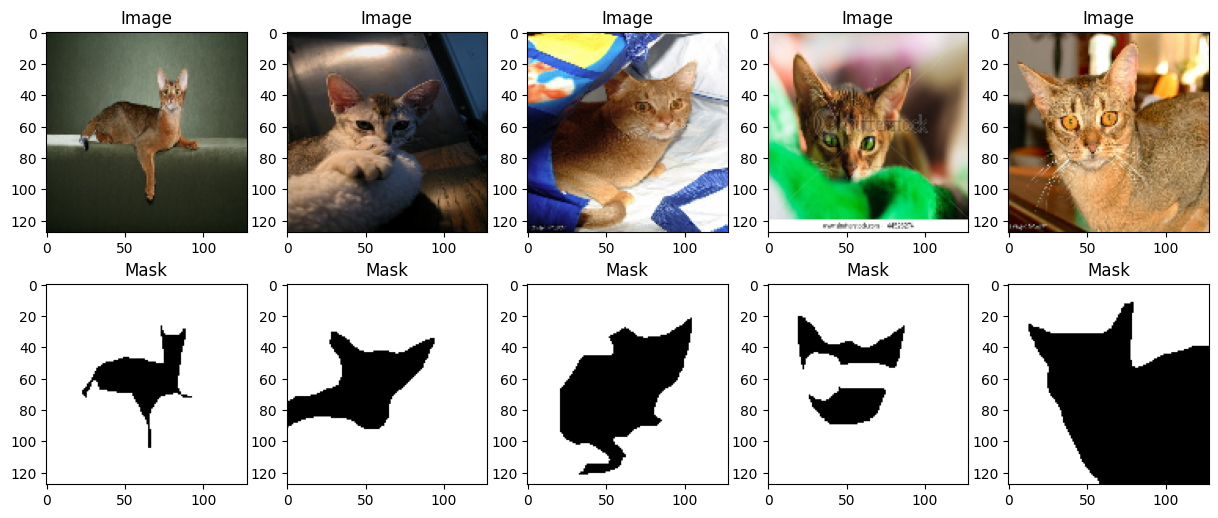

In [91]:
BATCH_SIZE = 32

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
display_sample(dataset)

In [92]:
train_dataset, val_dataset = train_val_split(image_files, mask_files, 0.2)

In [93]:
# Build the U-Net model
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 128, 128, 16)         448       ['input_4[0][0]']             
                                                                                                  
 conv2d_34 (Conv2D)          (None, 128, 128, 16)         2320      ['conv2d_33[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 16)           0         ['conv2d_34[0][0]']           
 g2D)                                                                                       

In [94]:
# Train the model (5 epochs for speed)
history = model.fit(train_dataset, validation_data = val_dataset, epochs=1, verbose = 1)
model.save("Unet.keras")

  20/1183 [..............................] - ETA: 1:23 - loss: 0.6491 - accuracy: 0.6780

KeyboardInterrupt: 

In [ ]:
# Load the original Keras model
loaded_keras_model = tf.keras.models.load_model("Unet.keras", compile=False)
# Benchmark the model
results_original = benchmark_keras_model(loaded_keras_model,  val_dataset, num_samples=100)

# Print comprehensive report
print("===== Benchmark Original Model Report =====")
print(f"Model: {'Original Keras Model (unet_model.keras)'}")
print(f"Model Size: {results_original['model_size_mb']:.2f} MB")
print(f"Average Inference Time per Sample: {results_original['avg_inference_time_ms']:.2f} ms")
print(f"Memory Usage (approx.): {results_original['memory_usage_mb']:.2f} MB")
print(f"Average Accuracy: {results_original['avg_accuracy']:.4f}")
print(f"Average Dice Coefficient: {results_original['avg_dice']:.4f}")
print(f"Average IoU: {results_original['avg_iou']:.4f}")
print("===========================")

Model Path Used: unet_saved_model
===== Benchmark Original Model Report =====
Model: Original Keras Model (unet_model.keras)
Model Size: 0.16 MB
Average Inference Time per Sample: 22.87 ms
Memory Usage (approx.): 41.52 MB
Average Accuracy: 0.7187
Average Dice Coefficient: 0.8260
Average IoU: 0.7187


# Post Training Quantization (PQT):

### Int 8 Quantization:

In [ ]:
# Quantize to int8
def representative_dataset():
    # Take a small subset of the training dataset
    for image, _ in train_dataset.take(100):
        # Yield the image as a single-element list (as expected by TFLite converter)
        yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_quant_model = converter.convert()

with open("unet_quant_int_8.tflite", "wb") as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp_s9if2_5/assets


INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp_s9if2_5/assets
/Users/raul/Projects/U-net/.conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-11 10:11:14.748313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-11 10:11:14.748334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-11 10:11:14.748687: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp_s9if2_5
2025-03-11 10:11:14.749769: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-11 10:11:14.749774: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/wb/7xv4jvys39x1c1wk7nw34

In [ ]:
tflite_model_path = "unet_quant_int_8.tflite"
results_quantized_int8 = benchmark_tflite_model(tflite_model_path, val_dataset, num_samples=100)

# Print comprehensive report
print("===== Benchmark  Quantized Model Report =====")
print(f"Model: {tflite_model_path}")
print(f"Model Size: {results_quantized_int8 ['model_size_mb']:.2f} MB")
print(f"Average Inference Time per Sample: {results_quantized_int8 ['avg_inference_time_ms']:.2f} ms")
print(f"Memory Usage (approx.): {results_quantized_int8 ['memory_usage_mb']:.2f} MB")
print(f"Average Accuracy: {results_quantized_int8 ['avg_accuracy']:.4f}")
print(f"Average Dice Coefficient: {results_quantized_int8 ['avg_dice']:.4f}")
print(f"Average IoU: {results_quantized_int8 ['avg_iou']:.4f}")
print("===========================")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


===== Benchmark  Quantized Model Report =====
Model: unet_quant_int_8.tflite
Model Size: 0.13 MB
Average Inference Time per Sample: 2.56 ms
Memory Usage (approx.): 1.28 MB
Average Accuracy: 0.7187
Average Dice Coefficient: 0.8260
Average IoU: 0.7187


# Quantization Aware Training (QAT)

In [ ]:
# Apply quantization-aware training
quantize_model = tfmot.quantization.keras.quantize_model

# Create a QAT-ready model
quantized_model = quantize_model(loaded_keras_model)

# Compile with lower learning rate (helps stabilization)
quantized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Train the model again
quantized_model.fit(train_dataset, epochs=1, verbose = 1)

# Convert to TFLite with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

with open("QAT_quantized_model.tflite", "wb") as f:
    f.write(tflite_model)

/Users/raul/Projects/U-net/.conda/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 128, 128, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1183/1183 [==============================] - 108s 91ms/step - loss: 0.0000e+00 - accuracy: 0.3234


ValueError: For full integer quantization, a `representative_dataset` must be specified.

In [ ]:
# Convert to TFLite with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

with open("QAT_quantized_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpz2yl_u3h/assets


INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpz2yl_u3h/assets
/Users/raul/Projects/U-net/.conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-11 10:21:59.622759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-11 10:21:59.622769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-11 10:21:59.622888: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpz2yl_u3h
2025-03-11 10:21:59.626463: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-11 10:21:59.626468: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/wb/7xv4jvys39x1c1wk7nw34

In [ ]:
tflite_model_path = "QAT_quantized_model.tflite"
results_QAT = benchmark_tflite_model(tflite_model_path, val_dataset, num_samples=100)

# Print comprehensive report
print("===== Benchmark  Quantized Model Report =====")
print(f"Model: {tflite_model_path}")
print(f"Model Size: {results_QAT ['model_size_mb']:.2f} MB")
print(f"Average Inference Time per Sample: {results_QAT ['avg_inference_time_ms']:.2f} ms")
print(f"Memory Usage (approx.): {results_QAT ['memory_usage_mb']:.2f} MB")
print(f"Average Accuracy: {results_QAT ['avg_accuracy']:.4f}")
print(f"Average Dice Coefficient: {results_QAT ['avg_dice']:.4f}")
print(f"Average IoU: {results_QAT ['avg_iou']:.4f}")

===== Benchmark  Quantized Model Report =====
Model: QAT_quantized_model.tflite
Model Size: 0.13 MB
Average Inference Time per Sample: 2.64 ms
Memory Usage (approx.): -1.27 MB
Average Accuracy: 0.2813
Average Dice Coefficient: 0.0000
Average IoU: 0.0000


# Prunning:

In [ ]:
# Define pruning schedule (50% sparsity by end)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=2000
    )
}

# Apply pruning
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(loaded_keras_model, **pruning_params)

# Compile and train with pruning
pruned_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
pruned_model.fit(train_dataset, epochs=1, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

# Strip pruning wrappers and export
pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

pruned_model.export("unet_pruned_saved_model")

1183/1183 [==============================] - 87s 72ms/step - loss: 0.4444 - accuracy: 0.7782
INFO:tensorflow:Assets written to: unet_pruned_saved_model/assets


INFO:tensorflow:Assets written to: unet_pruned_saved_model/assets


Saved artifact at 'unet_pruned_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 128, 128, 3)
  Returns:
    float32 Tensor, shape=(None, 128, 128, 1)


In [ ]:
# Load the original Keras model
# Benchmark the model
results_prunned = benchmark_keras_model(pruned_model,  val_dataset, num_samples=100)

# Print comprehensive report
print("===== Benchmark Original Model Report =====")
print(f"Model: {'Prunned Model (unet_model.keras)'}")
print(f"Model Size: {results_prunned['model_size_mb']:.2f} MB")
print(f"Average Inference Time per Sample: {results_prunned['avg_inference_time_ms']:.2f} ms")
print(f"Memory Usage (approx.): {results_prunned['memory_usage_mb']:.2f} MB")
print(f"Average Accuracy: {results_prunned['avg_accuracy']:.4f}")
print(f"Average Dice Coefficient: {results_prunned['avg_dice']:.4f}")
print(f"Average IoU: {results_prunned['avg_iou']:.4f}")
print("===========================")

Model Path Used: unet_saved_model
===== Benchmark Original Model Report =====
Model: Prunned Model (unet_model.keras)
Model Size: 0.16 MB
Average Inference Time per Sample: 21.81 ms
Memory Usage (approx.): 39.28 MB
Average Accuracy: 0.7187
Average Dice Coefficient: 0.8260
Average IoU: 0.7187


# Prunning protecting skip connections:

In [ ]:
# Define pruning parameters
pruning_params = {
    "pruning_schedule": tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.2,  # Start pruning at 20%
        final_sparsity=0.8,    # Prune up to 80% of weights
        begin_step=2000,       # Start pruning after 2000 steps
        end_step=10000         # Stop pruning at 10000 steps
    )
}

# Helper function: Apply pruning only to Conv2D layers
def apply_pruning(layer):
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer  # Skip all other layers (including Concatenate)

# Rebuild the model with pruned layers
pruned_model = tf.keras.models.clone_model(
    loaded_keras_model,
    clone_function=apply_pruning  # Apply pruning only to Conv2D layers
)

print("Pruning applied selectively to Conv2D layers. ✅")

Pruning applied selectively to Conv2D layers. ✅


In [ ]:
# Compile with a lower learning rate to stabilize pruning
pruned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  # Lower LR for stability
                     loss="binary_crossentropy",  # Adjust if using multi-class segmentation
                     metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)])

# Add pruning step callback
pruning_callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
]

# Fine-tune the pruned model
pruned_model.fit(train_dataset, 
                 epochs=1, 
                 validation_data=val_dataset, 
                 callbacks=pruning_callbacks)  # Add pruning step callback

print("Fine-tuning complete!")

1183/1183 [==============================] - 95s 80ms/step - loss: 0.3789 - accuracy: 0.8254 - mean_io_u_1: 0.1504 - val_loss: 0.7764 - val_accuracy: 0.7016 - val_mean_io_u_1: 0.1492
Fine-tuning complete!


In [ ]:
# Remove pruning operations
pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Save the final pruned model
pruned_model.save("Unet_Pruned_Skip.keras")

print("Pruned model saved successfully!")

Pruned model saved successfully!


In [ ]:
# Load the original Keras model
# Benchmark the model
results_prunned_skip = benchmark_keras_model(pruned_model,  val_dataset, num_samples=100)

# Print comprehensive report
print("===== Benchmark Original Model Report =====")
print(f"Model: {'Prunned Model (unet_model.keras)'}")
print(f"Model Size: {results_prunned_skip['model_size_mb']:.2f} MB")
print(f"Average Inference Time per Sample: {results_prunned_skip['avg_inference_time_ms']:.2f} ms")
print(f"Memory Usage (approx.): {results_prunned_skip['memory_usage_mb']:.2f} MB")
print(f"Average Accuracy: {results_prunned_skip['avg_accuracy']:.4f}")
print(f"Average Dice Coefficient: {results_prunned_skip['avg_dice']:.4f}")
print(f"Average IoU: {results_prunned_skip['avg_iou']:.4f}")
print("===========================")

Model Path Used: unet_saved_model
===== Benchmark Original Model Report =====
Model: Prunned Model (unet_model.keras)
Model Size: 0.16 MB
Average Inference Time per Sample: 23.46 ms
Memory Usage (approx.): 77.81 MB
Average Accuracy: 0.7187
Average Dice Coefficient: 0.8260
Average IoU: 0.7187


In [ ]:
# Convert pruned model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the pruned model to TFLite format
tflite_pruned_model = converter.convert()

# Save the quantized & pruned model
with open("Unet_Pruned_Quant.tflite", "wb") as f:
    f.write(tflite_pruned_model)

print("Pruned TFLite model successfully created! 🚀")

INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpb0ubw3x6/assets


INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpb0ubw3x6/assets


Pruned TFLite model successfully created! 🚀


2025-03-11 10:47:03.785374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-11 10:47:03.785386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-11 10:47:03.785521: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpb0ubw3x6
2025-03-11 10:47:03.786538: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-11 10:47:03.786543: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpb0ubw3x6
2025-03-11 10:47:03.789569: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-03-11 10:47:03.812499: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpb0ubw3x6
2025-03-

In [ ]:
# Load the original Keras model
# Benchmark the model
results_prunned_skip_quant = benchmark_tflite_model("Unet_Pruned_Quant.tflite",  val_dataset, num_samples=100)

# Print comprehensive report
print("===== Benchmark Original Model Report =====")
print(f"Model: {'Prunned Model (unet_model.keras)'}")
print(f"Model Size: {results_prunned_skip_quant['model_size_mb']:.2f} MB")
print(f"Average Inference Time per Sample: {results_prunned_skip_quant['avg_inference_time_ms']:.2f} ms")
print(f"Memory Usage (approx.): {results_prunned_skip_quant['memory_usage_mb']:.2f} MB")
print(f"Average Accuracy: {results_prunned_skip_quant['avg_accuracy']:.4f}")
print(f"Average Dice Coefficient: {results_prunned_skip_quant['avg_dice']:.4f}")
print(f"Average IoU: {results_prunned_skip_quant['avg_iou']:.4f}")
print("===========================")

===== Benchmark Original Model Report =====
Model: Prunned Model (unet_model.keras)
Model Size: 0.13 MB
Average Inference Time per Sample: 5.04 ms
Memory Usage (approx.): 4.34 MB
Average Accuracy: 0.7187
Average Dice Coefficient: 0.8260
Average IoU: 0.7187


In [113]:
# Define your model results (Ensure these variables are defined in your script)
results = {
    "Original_Model": results_original,
    "Quantized_(INT8)": results_quantized_int8,
    "QAT": results_QAT,
    "Pruned": results_prunned,
    "Pruned-(Skip_Connections_Protected)": results_prunned_skip,
    "Pruned_Quantized-(Skip_Connections_Protected)": results_prunned_skip_quant
}

# Convert dictionary to DataFrame and reset index to have model names as a column
df_results = pd.DataFrame.from_dict(results, orient="index").reset_index()

# Rename the index column to 'Model'
df_results.rename(columns={'index': 'Model'}, inplace=True)
#df_results = df_results.style.set_properties(**{'text-align': 'center'})
df_results = df_results.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},  # Center-align column headers
    {'selector': 'td', 'props': [('text-align', 'center')]}   # Center-align table cells
]).hide(axis="index")  # ✅ Hide the left-side index

# Display the DataFrame
df_results

Model,model_size_mb,avg_inference_time_ms,memory_usage_mb,avg_accuracy,avg_dice,avg_iou
Original_Model,0.156208,22.873707,41.515625,0.718666,0.825968,0.718666
Quantized_(INT8),0.129494,2.559228,1.281250,0.718666,0.825968,0.718666
QAT,0.132301,2.644768,-1.265625,0.281334,0.000000,0.000000
Pruned,0.156208,21.810863,39.281250,0.718666,0.825968,0.718666
Pruned-(Skip_Connections_Protected),0.156208,23.460732,77.812500,0.718666,0.825968,0.718666
Pruned_Quantized-(Skip_Connections_Protected),0.126068,5.036883,4.343750,0.718666,0.825968,0.718666


# Mixed Precision:

In [115]:
# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Rebuild and train the model
model_mixed = build_unet()
model_mixed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_mixed.fit(train_dataset, epochs=1)

# Export
model_mixed.export("unet_mixed_saved_model")

1183/1183 [==============================] - 92s 78ms/step - loss: 2.3010e-04 - accuracy: 0.6908
INFO:tensorflow:Assets written to: unet_mixed_saved_model/assets


INFO:tensorflow:Assets written to: unet_mixed_saved_model/assets


Saved artifact at 'unet_mixed_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 128, 128, 3)
  Returns:
    float16 Tensor, shape=(None, 128, 128, 1)


In [116]:
# Load the original Keras model
# Benchmark the model
results_mixed_precision = benchmark_keras_model(model_mixed,  val_dataset, num_samples=100)

# Print comprehensive report
print("===== Benchmark Mixed Precision Model Report =====")
print(f"Model: {'Prunned Model (unet_model.keras)'}")
print(f"Model Size: {results_mixed_precision['model_size_mb']:.2f} MB")
print(f"Average Inference Time per Sample: {results_mixed_precision['avg_inference_time_ms']:.2f} ms")
print(f"Memory Usage (approx.): {results_mixed_precision['memory_usage_mb']:.2f} MB")
print(f"Average Accuracy: {results_mixed_precision['avg_accuracy']:.4f}")
print(f"Average Dice Coefficient: {results_mixed_precision['avg_dice']:.4f}")
print(f"Average IoU: {results_mixed_precision['avg_iou']:.4f}")
print("===========================")

Model Path Used: unet_saved_model
===== Benchmark Mixed Precision Model Report =====
Model: Prunned Model (unet_model.keras)
Model Size: 0.16 MB
Average Inference Time per Sample: 25.69 ms
Memory Usage (approx.): 181.62 MB
Average Accuracy: 0.7187
Average Dice Coefficient: 0.8260
Average IoU: 0.7187


In [117]:
# Define your model results (Ensure these variables are defined in your script)
results = {
    "Original_Model": results_original,
    "Quantized_(INT8)": results_quantized_int8,
    "QAT": results_QAT,
    "Pruned": results_prunned,
    "Pruned-(Skip_Connections_Protected)": results_prunned_skip,
    "Pruned_Quantized-(Skip_Connections_Protected)": results_prunned_skip_quant,
    "Mixed_Precision": results_mixed_precision
}

# Convert dictionary to DataFrame and reset index to have model names as a column
df_results = pd.DataFrame.from_dict(results, orient="index").reset_index()

# Rename the index column to 'Model'
df_results.rename(columns={'index': 'Model'}, inplace=True)
#df_results = df_results.style.set_properties(**{'text-align': 'center'})
df_results = df_results.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},  # Center-align column headers
    {'selector': 'td', 'props': [('text-align', 'center')]}   # Center-align table cells
]).hide(axis="index")  # ✅ Hide the left-side index

# Display the DataFrame
df_results

Model,model_size_mb,avg_inference_time_ms,memory_usage_mb,avg_accuracy,avg_dice,avg_iou
Original_Model,0.156208,22.873707,41.515625,0.718666,0.825968,0.718666
Quantized_(INT8),0.129494,2.559228,1.281250,0.718666,0.825968,0.718666
QAT,0.132301,2.644768,-1.265625,0.281334,0.000000,0.000000
Pruned,0.156208,21.810863,39.281250,0.718666,0.825968,0.718666
Pruned-(Skip_Connections_Protected),0.156208,23.460732,77.812500,0.718666,0.825968,0.718666
Pruned_Quantized-(Skip_Connections_Protected),0.126068,5.036883,4.343750,0.718666,0.825968,0.718666
Mixed_Precision,0.156208,25.686915,181.625000,0.718666,0.825968,0.718666
